In [1]:
import os, glob, shutil, math, json, datetime
from pathlib import Path

import numpy as np
import PIL.Image as Image
from PIL import UnidentifiedImageError
from tqdm.notebook import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
from collections import defaultdict


In [2]:
if torch.cuda.is_available():
    print("The code will run on GPU.")
elif torch.backends.mps.is_available():
    print("The code will run on MPS.")
else:
    print("The code will run on CPU. Go to Edit->Notebook Settings and choose GPU as the hardware accelerator")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


The code will run on MPS.


In [ ]:
# Colab Drive
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [3]:
# Utils
def timestamp():
    return datetime.datetime.now().strftime("%Y%m%d_%H%M%S")

OUTDIR = Path(f"./outputs/{timestamp()}")
OUTDIR.mkdir(parents=True, exist_ok=True)
print("Saving artifacts to:", OUTDIR)

Saving artifacts to: outputs/20250928_095737


In [15]:
# Cell 2: config
ROOT = Path('../data/hotdog_nothotdog')  # 数据根目录（含 train/ test/）
IMG = 224                 # 也可用 128
BATCH = 64
WORKERS = 0

# 训练配置
EPOCHS = 10
LR = 1e-3
OPTIMIZER = 'adam'        # 'adam' or 'sgd'
SCHEDULER = 'cosine'      # 'cosine' or 'step'

# 归一化与增强
USE_DATASET_NORM = False   # True=用训练集统计的 mean/std；False=用 ImageNet 常量
# AUGMENT_KEY = "G_hflip_P_light_R_erasing"
AUGMENT_KEY = "Baseline_RESIZE"


# 显著图
SALIENCY_K = 8
SALIENCY_SIGMA = 0.15
SALIENCY_N = 20


In [5]:
# 新增：可复现随机性
import random
SEED = 42
random.seed(SEED); np.random.seed(SEED)
torch.manual_seed(SEED); #torch.cuda.manual_seed_all(SEED)
#torch.backends.cudnn.deterministic = True
#torch.backends.cudnn.benchmark = False


In [6]:
# dataset class
class Hotdog_NotHotdog(torch.utils.data.Dataset):
    def __init__(self, train, transform, data_path=ROOT):
        self.transform = transform
        data_path = os.path.join(str(data_path), 'train' if train else 'test')
        image_classes = [os.path.split(d)[1] for d in glob.glob(data_path+'/*') if os.path.isdir(d)]
        image_classes.sort()
        self.name_to_label = {c:i for i,c in enumerate(image_classes)}
        # 匹配多种扩展名
        self.image_paths = []
        for ext in ('*.jpg','*.jpeg','*.png','*.JPG','*.JPEG','*.PNG'):
            self.image_paths += glob.glob(os.path.join(data_path, '*', ext))
        self.image_paths.sort()

    def __len__(self): return len(self.image_paths)

    def __getitem__(self, idx):
        p = self.image_paths[idx]
        with Image.open(p) as im:
            im = im.convert('RGB')
        c = os.path.split(os.path.split(p)[0])[1]
        y = self.name_to_label[c]
        X = self.transform(im)
        return X, y


In [7]:
# scan & clean
def scan_and_clean_dataset(root):
    root = Path(root)
    broken_dir = root / "_broken"
    broken_dir.mkdir(exist_ok=True)

    stats = {}
    bad_files = []

    for split in ['train', 'test']:
        stats[split] = {}
        split_dir = root / split
        classes = [d.name for d in split_dir.iterdir() if d.is_dir()]
        for c in sorted(classes):
            cls_dir = split_dir / c
            files = sum([list(cls_dir.glob(pat)) for pat in ('*.jpg','*.jpeg','*.png','*.JPG','*.JPEG','*.PNG')], [])
            ok = 0
            for fp in files:
                try:
                    with Image.open(fp) as im:
                        im.verify()
                    ok += 1
                except (UnidentifiedImageError, OSError):
                    bad_files.append(fp)
            stats[split][c] = ok

    for fp in bad_files:
        target = broken_dir / fp.name
        shutil.move(str(fp), target)

    print(f"[SCAN] Done. Moved {len(bad_files)} broken files to: {broken_dir}")
    return stats

def pretty_print_stats(stats):
    print("Dataset summary:")
    for split, d in stats.items():
        total = sum(d.values())
        print(f"  {split}: total={total}")
        for c, n in d.items():
            print(f"    - {c}: {n}")

stats = scan_and_clean_dataset(ROOT)
pretty_print_stats(stats)


[SCAN] Done. Moved 0 broken files to: ../data/hotdog_nothotdog/_broken
Dataset summary:
  train: total=2047
    - hotdog: 1075
    - nothotdog: 972
  test: total=1862
    - hotdog: 895
    - nothotdog: 967


In [8]:
# Cell 5: compute mean/std
import torchvision.transforms as T

@torch.no_grad()
def calc_mean_std(loader, max_batches=None):
    psum = torch.zeros(3); psq = torch.zeros(3); cnt = 0
    for i, (x, _) in enumerate(loader):
        if max_batches is not None and i >= max_batches: break
        b,c,h,w = x.shape
        x = x.view(b, c, -1)
        psum += x.sum(dim=[0,2])
        psq  += (x**2).sum(dim=[0,2])
        cnt  += b*h*w
    mean = psum / cnt
    var  = psq  / cnt - mean**2
    std  = torch.sqrt(var.clamp_min(1e-12))
    return mean.tolist(), std.tolist()

# 暂时先不Normalize，只Resize+ToTensor便于统计
pre_tfms = T.Compose([T.Resize(256), T.CenterCrop(IMG), T.ToTensor()])
tmp_loader = DataLoader(Hotdog_NotHotdog(train=True, transform=pre_tfms, data_path=ROOT),
                        batch_size=64, shuffle=False, num_workers=WORKERS)

if USE_DATASET_NORM:
    TRAINSET_MEAN, TRAINSET_STD = calc_mean_std(tmp_loader)
    EVALSET_MEAN,   EVALSET_STD = TRAINSET_MEAN, TRAINSET_STD
else:
    TRAINSET_MEAN, TRAINSET_STD = [0.485,0.456,0.406], [0.229,0.224,0.225]
    EVALSET_MEAN,   EVALSET_STD = TRAINSET_MEAN, TRAINSET_STD

print("mean:", TRAINSET_MEAN, "std:", TRAINSET_STD)
#with open(OUTDIR/"norm.json","w") as f:
#    json.dump({"mean":TRAINSET_MEAN,"std":TRAINSET_STD}, f, indent=2)


mean: [0.485, 0.456, 0.406] std: [0.229, 0.224, 0.225]


In [9]:
# Cell 6: augmentation dictionary + eval transform
def build_transforms(img_size=IMG, augment_key="Baseline_RESIZE"):
    base_tfms_list = [transforms.RandomResizedCrop(img_size, scale=(1.0,1.0))]
    common_train = [transforms.ToTensor(), transforms.Normalize(TRAINSET_MEAN, TRAINSET_STD)]

    eval_tfms = transforms.Compose([
        transforms.Resize(256), transforms.CenterCrop(img_size),
        transforms.ToTensor(), transforms.Normalize(EVALSET_MEAN, EVALSET_STD)
    ])

    train_tfms = {
        "Baseline_RESIZE": transforms.Compose([transforms.Resize(256), transforms.CenterCrop(img_size),
                                               transforms.ToTensor(), transforms.Normalize(TRAINSET_MEAN, TRAINSET_STD)]),
        "Baseline": transforms.Compose(base_tfms_list + common_train),
        "G_hflip": transforms.Compose(base_tfms_list + [transforms.RandomHorizontalFlip(0.5)] + common_train),
        "G_rot": transforms.Compose(base_tfms_list + [transforms.RandomRotation(10, fill=0)] + common_train),
        "P_light": transforms.Compose(base_tfms_list + [transforms.RandomApply([transforms.ColorJitter(0.15,0.15,0.15,0.03)], p=0.4)] + common_train),
        "P_med": transforms.Compose(base_tfms_list + [transforms.RandomApply([transforms.ColorJitter(0.3,0.3,0.3,0.08)], p=0.6)] + common_train),
        "G_gaussian_blur": transforms.Compose(base_tfms_list + [transforms.GaussianBlur(kernel_size=(5,5), sigma=(0.1,2.0))] + common_train),
        "R_erasing": transforms.Compose(base_tfms_list + [transforms.RandomHorizontalFlip(0.5)] + common_train + [
            transforms.RandomErasing(p=0.1, scale=(0.02,0.12), ratio=(0.3,3.3), inplace=False)
        ]),
        "G_hflip_P_light_R_erasing": transforms.Compose(base_tfms_list + [
            transforms.RandomHorizontalFlip(0.5),
            transforms.RandomApply([transforms.ColorJitter(0.15,0.15,0.15,0.03)], p=0.4),
        ] + common_train + [
            transforms.RandomErasing(p=0.1, scale=(0.02,0.12), ratio=(0.3,3.3), inplace=False)
        ]),
        "A_autoaugment": transforms.Compose([
            transforms.AutoAugment(transforms.AutoAugmentPolicy.IMAGENET),
            transforms.Resize(256), transforms.CenterCrop(img_size),
            transforms.ToTensor(), transforms.Normalize(TRAINSET_MEAN, TRAINSET_STD),
        ]),
        "A_randaugment": transforms.Compose([
            transforms.RandAugment(num_ops=2, magnitude=9),
            transforms.Resize(256), transforms.CenterCrop(img_size),
            transforms.ToTensor(), transforms.Normalize(TRAINSET_MEAN, TRAINSET_STD),
        ]),
    }
    if augment_key not in train_tfms:
        raise KeyError(f"{augment_key} not in {list(train_tfms.keys())}")
    return train_tfms[augment_key], eval_tfms

train_transform, test_transform = build_transforms(IMG, AUGMENT_KEY)
print("Using augmentation:", AUGMENT_KEY)


Using augmentation: Baseline_RESIZE


In [17]:
# 新增：Cell 7：train/val/test 三分
from torch.utils.data import Subset, DataLoader
import numpy as np

# 构建两个“同源”Dataset（同一文件次序），但 transform 不同：
#  - 训练子集用训练增强（train_transform）
#  - 验证子集用评估风格（test_transform）
full_train_for_train = Hotdog_NotHotdog(train=True,  transform=train_transform, data_path=ROOT)
full_train_for_val   = Hotdog_NotHotdog(train=True,  transform=test_transform,  data_path=ROOT)
testset              = Hotdog_NotHotdog(train=False, transform=test_transform,  data_path=ROOT)

# 80/20 划分索引（可复现）
N = len(full_train_for_train)
idx = np.arange(N)
rng = np.random.default_rng(SEED)
rng.shuffle(idx)
split = int(0.8 * N)
train_idx, val_idx = idx[:split], idx[split:]

# 用相同索引对子集化
train_subset = Subset(full_train_for_train, train_idx)  # 训练增强
val_subset   = Subset(full_train_for_val,   val_idx)    # 验证不做训练增强

# 三个 DataLoader
train_loader = DataLoader(train_subset, batch_size=BATCH, shuffle=True,  num_workers=WORKERS)
val_loader   = DataLoader(val_subset,   batch_size=BATCH, shuffle=False, num_workers=WORKERS)
test_loader  = DataLoader(testset,      batch_size=BATCH, shuffle=False, num_workers=WORKERS)

# 类名（与标签索引一致）
class_names = [k for k,_ in sorted(full_train_for_train.name_to_label.items(), key=lambda kv: kv[1])]

print(f"train/val/test = {len(train_subset)}/{len(val_subset)}/{len(testset)}")


train/val/test = 1637/410/1862


In [11]:
# smallcnn smallcnn+BN smallcnn+dropout resnet18
from torchvision import models

class SmallCNN(nn.Module):
    def __init__(self, num_classes=2, use_bn=False, dropout_p=0.0):
        super().__init__()
        def blk(in_c, out_c):
            # 可选 BN：Conv → (BN) → ReLU → Pool
            layers = [nn.Conv2d(in_c, out_c, 3, padding=1)]
            if use_bn:
                layers.append(nn.BatchNorm2d(out_c))
            layers += [nn.ReLU(), nn.MaxPool2d(2)]
            return nn.Sequential(*layers)

        self.features = nn.Sequential(
            blk(3,   32),
            blk(32,  64),
            blk(64, 128),
        )
        # Conv2d(3→32, k3, pad1) → ReLU → MaxPool2d(2)
        # Conv2d(32→64, k3, pad1) → ReLU → MaxPool2d(2)
        # Conv2d(64→128, k3, pad1) → ReLU → MaxPool2d(2)

        # 分类头：Flatten → FC → (Dropout) → ReLU → FC(num_classes)
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128*(IMG//8)*(IMG//8), 128),
            nn.Dropout(p=dropout_p) if dropout_p > 0 else nn.Identity(),
            nn.ReLU(),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        return self.classifier(self.features(x))

def build_model(kind='base', num_classes=2, pretrained=True, freeze_backbone=False):
    if kind == 'base':  # SmallCNN 原版（无 BN / 无 Dropout）
        model = SmallCNN(num_classes=num_classes, use_bn=False, dropout_p=0.0)
    elif kind == 'base_bn':  # SmallCNN + BN
        model = SmallCNN(num_classes=num_classes, use_bn=True, dropout_p=0.0)
    elif kind == 'base_do':  # SmallCNN + Dropout（p=0.3 可调）
        model = SmallCNN(num_classes=num_classes, use_bn=False, dropout_p=0.3)
    elif kind == 'resnet18':
        m = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1 if pretrained else None)
        if freeze_backbone:
            for p in m.parameters(): p.requires_grad = False
        m.fc = nn.Linear(m.fc.in_features, num_classes)
        model = m
    else:
        raise ValueError("Unknown kind")
    return model.to(device)


In [12]:
# Cell 9 (REPLACE): training with val early-stop
def accuracy_from_logits(logits, y):
    pred = logits.argmax(dim=1)
    return (pred == y).float().mean().item()

def train_one_model(kind='base', train_loader=None, val_loader=None,
                    epochs=10, lr=1e-3, optimizer_name='adam',
                    scheduler_name='cosine', patience=5,
                    freeze_backbone=False, pretrained=True):
    assert train_loader is not None and val_loader is not None, "need train_loader & val_loader"

    model = build_model(kind, num_classes=2, pretrained=pretrained, freeze_backbone=freeze_backbone)

    if optimizer_name.lower() == 'adam':
        opt = torch.optim.Adam(model.parameters(), lr=lr)
    elif optimizer_name.lower() == 'sgd':
        opt = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9, nesterov=True)
    else:
        raise ValueError("optimizer_name in {'adam','sgd'}")

    if scheduler_name == 'cosine':
        sched = torch.optim.lr_scheduler.CosineAnnealingLR(opt, T_max=epochs)
    elif scheduler_name == 'step':
        sched = torch.optim.lr_scheduler.StepLR(opt, step_size=max(1,epochs//3), gamma=0.1)
    else:
        sched = None

    scaler = torch.cuda.amp.GradScaler(enabled=(device.type=='cuda'))
    criterion = nn.CrossEntropyLoss()
    hist = defaultdict(list); best_val_acc = 0.0; best_state = None; wait = 0

    for ep in range(1, epochs+1):
        # ---- train ----
        model.train(); train_loss=train_acc=0.0; n_train=0
        for X, y in train_loader:
            X, y = X.to(device), y.to(device, dtype=torch.long)
            opt.zero_grad(set_to_none=True)
            with torch.cuda.amp.autocast(enabled=(device.type=='cuda')):
                logits = model(X); loss = criterion(logits, y)
            scaler.scale(loss).backward(); scaler.step(opt); scaler.update()

            train_loss += loss.item()*X.size(0)
            train_acc  += (logits.argmax(1)==y).sum().item()
            n_train    += X.size(0)

        # ---- validate ----
        model.eval(); val_loss=val_acc=0.0; n_val=0
        with torch.no_grad():
            for X,y in val_loader:
                X, y = X.to(device), y.to(device, dtype=torch.long)
                logits = model(X); loss = criterion(logits, y)
                val_loss += loss.item()*X.size(0)
                val_acc  += (logits.argmax(1)==y).sum().item()
                n_val    += X.size(0)

        # epoch end
        train_loss/=max(1,n_train); val_loss/=max(1,n_val)
        train_acc /=max(1,n_train); val_acc /=max(1,n_val)
        hist['train_loss'].append(train_loss); hist['val_loss'].append(val_loss)
        hist['train_acc'].append(train_acc);  hist['val_acc'].append(val_acc)

        if sched: sched.step()  # <-- step at epoch end

        # early stop on val
        if val_acc > best_val_acc + 1e-4:
            best_val_acc = val_acc
            best_state = {k:v.cpu().clone() for k,v in model.state_dict().items()}
            wait = 0
        else:
            wait += 1
            if wait >= patience:
                print(f"[EarlyStop] epoch={ep}, best_val_acc={best_val_acc:.4f}")
                break

        print(f"Epoch {ep:03d}  loss {train_loss:.4f}/{val_loss:.4f}  acc {train_acc:.3f}/{val_acc:.3f}")

    if best_state is not None:
        model.load_state_dict(best_state)
        torch.save(best_state, OUTDIR/"best.ckpt")

    return model, hist, best_val_acc

def plot_curves(hists, labels, title="Training curves"):
    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    for h,lab in zip(hists, labels):
        plt.plot(h['train_loss'], label=f"{lab}-train")
        plt.plot(h['val_loss'],   label=f"{lab}-val", linestyle='--')
    plt.xlabel("epoch"); plt.ylabel("loss"); plt.title(title+" (loss)"); plt.legend(); plt.grid(alpha=0.3)
    plt.subplot(1,2,2)
    for h,lab in zip(hists, labels):
        plt.plot(h['train_acc'], label=f"{lab}-train")
        plt.plot(h['val_acc'],   label=f"{lab}-val", linestyle='--')
    plt.xlabel("epoch"); plt.ylabel("accuracy"); plt.title(title+" (acc)"); plt.legend(); plt.grid(alpha=0.3)
    plt.tight_layout(); plt.savefig(OUTDIR/"curves.png"); plt.show()


In [19]:
# Eval helper (drop-in)
import math, numpy as np, matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

def eval_and_report(model, loader, class_names=None, max_show=16, tag=""):
    model.eval()
    all_y, all_p = [], []
    wrong_imgs, wrong_pred_true = [], []
    with torch.no_grad():
        for X, y in loader:
            X = X.to(device); y = y.to(device)
            logits = model(X)
            p = logits.argmax(1)
            all_y.append(y.cpu().numpy()); all_p.append(p.cpu().numpy())

            mism = (p != y)
            if mism.any():
                xs = X[mism].cpu()
                ys = y[mism].cpu().numpy()
                ps = p[mism].cpu().numpy()
                for i in range(xs.size(0)):
                    if len(wrong_imgs) >= max_show: break
                    wrong_imgs.append(xs[i]); wrong_pred_true.append((ps[i], ys[i]))

    all_y = np.concatenate(all_y); all_p = np.concatenate(all_p)
    acc = float((all_y == all_p).mean())
    print(f"Accuracy: {acc:.4f}\n")
    report_txt = classification_report(all_y, all_p, target_names=class_names, digits=4) if class_names else classification_report(all_y, all_p, digits=4)
    print(report_txt)

    # ===== 仅此处最小改动：带 tag 的文件名 =====
    tag = f"_{tag}" if tag else ""
    try:
        (OUTDIR).mkdir(parents=True, exist_ok=True)
        with open(OUTDIR / f"classification_report{tag}.txt","w") as f:
            f.write(f"Accuracy: {acc:.4f}\n\n{report_txt}")
        cm = confusion_matrix(all_y, all_p)
        disp = ConfusionMatrixDisplay(cm, display_labels=class_names if class_names else None)
        fig, ax = plt.subplots(figsize=(4,4)); disp.plot(ax=ax, colorbar=False, values_format='d')
        plt.tight_layout(); plt.savefig(OUTDIR / f"confusion_matrix{tag}.png"); plt.show()
    except Exception as e:
        print("[warn] save artifacts failed:", e)

    # 误分拼贴（最多 max_show 张）
    if wrong_imgs:
        k = min(max_show, len(wrong_imgs)); cols = 8; rows = math.ceil(k/cols)
        plt.figure(figsize=(cols*2, rows*2))
        for i in range(k):
            plt.subplot(rows, cols, i+1)
            img = (wrong_imgs[i]-wrong_imgs[i].min())/(wrong_imgs[i].max()-wrong_imgs[i].min()+1e-6)
            pt  = wrong_pred_true[i]
            ttl = f"pred:{class_names[pt[0]] if class_names else pt[0]}\ntrue:{class_names[pt[1]] if class_names else pt[1]}"
            plt.imshow(img.permute(1,2,0)); plt.axis('off'); plt.title(ttl, fontsize=9)
        plt.suptitle("Misclassified examples"); plt.tight_layout(); plt.savefig(OUTDIR / f"misclassified{tag}.png"); plt.show()

    return acc


/var/folders/k6/18s4hr7n4xv6tk2jrjw6t3wr0000gn/T/ipykernel_24215/3209418428.py:28: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=(device.type=='cuda'))
/var/folders/k6/18s4hr7n4xv6tk2jrjw6t3wr0000gn/T/ipykernel_24215/3209418428.py:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device.type=='cuda')):


Epoch 001  loss 1.0380/0.6150  acc 0.556/0.707
Epoch 002  loss 0.5685/0.6488  acc 0.720/0.666
Epoch 003  loss 0.5272/0.5017  acc 0.748/0.741
Epoch 004  loss 0.5249/0.5187  acc 0.757/0.754
Epoch 005  loss 0.4815/0.5140  acc 0.777/0.739
Epoch 006  loss 0.4587/0.4903  acc 0.789/0.749
Epoch 007  loss 0.4392/0.4835  acc 0.801/0.746
Epoch 008  loss 0.4204/0.4697  acc 0.806/0.756
Epoch 009  loss 0.4033/0.4754  acc 0.824/0.751
Epoch 010  loss 0.3990/0.4661  acc 0.826/0.780
Epoch 001  loss 6.2498/2.4579  acc 0.622/0.676
Epoch 002  loss 0.7868/0.5372  acc 0.735/0.763
Epoch 003  loss 0.5043/0.6310  acc 0.776/0.702
Epoch 004  loss 0.4697/0.5513  acc 0.794/0.746
Epoch 005  loss 0.3813/0.5040  acc 0.836/0.773
Epoch 006  loss 0.3523/0.5147  acc 0.860/0.768
Epoch 007  loss 0.3390/0.5308  acc 0.863/0.761
Epoch 008  loss 0.3258/0.4966  acc 0.871/0.773
Epoch 009  loss 0.3024/0.4925  acc 0.886/0.778
Epoch 010  loss 0.2925/0.4908  acc 0.898/0.783
Epoch 001  loss 0.9397/0.5958  acc 0.637/0.698
Epoch 002  lo

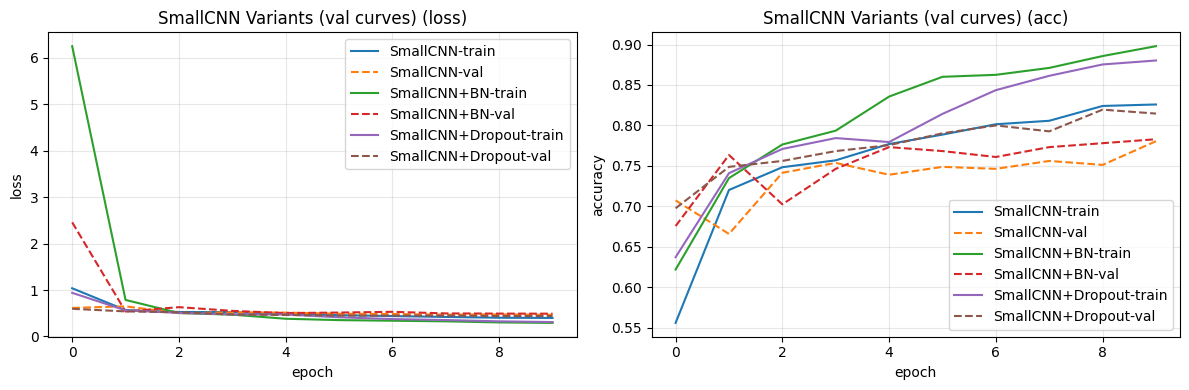

[VAL] best acc  base: 0.780 | base_bn: 0.783 | base_do: 0.820
Epoch 001  loss 0.4589/0.5895  acc 0.801/0.773
Epoch 002  loss 0.2648/1.8624  acc 0.900/0.556
Epoch 003  loss 0.1371/0.5130  acc 0.946/0.856
Epoch 004  loss 0.0756/0.4140  acc 0.971/0.876
Epoch 005  loss 0.0394/0.5913  acc 0.984/0.839
Epoch 006  loss 0.0243/0.5230  acc 0.995/0.849
Epoch 007  loss 0.0111/0.4021  acc 0.997/0.902
Epoch 008  loss 0.0041/0.3615  acc 0.999/0.900
Epoch 009  loss 0.0019/0.3621  acc 1.000/0.898
Epoch 010  loss 0.0013/0.3654  acc 1.000/0.893
[VAL] resnet18 best acc: 0.902


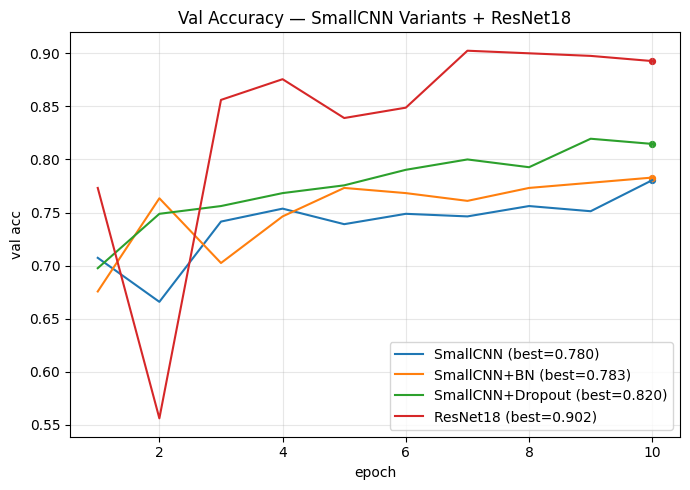


== SmallCNN on TEST ==


TypeError: eval_and_report() got an unexpected keyword argument 'tag'

In [18]:
# Train 3x SmallCNN + ResNet18, plot all-in-one, eval on TEST

# 0) helper: single-figure multi-model plot
def plot_all_on_one(hists, labels, metric='val_acc', title='Validation Accuracy (all models)'):
    import matplotlib.pyplot as plt
    plt.figure(figsize=(7,5))
    for h, lab in zip(hists, labels):
        y = h[metric]
        x = list(range(1, len(y)+1))
        plt.plot(x, y, label=f"{lab} (best={max(y):.3f})")
        plt.scatter([x[-1]], [y[-1]], s=18)
    plt.xlabel("epoch"); plt.ylabel(metric.replace('_',' '))
    plt.title(title); plt.grid(alpha=0.3); plt.legend()
    try:
        OUTDIR.mkdir(parents=True, exist_ok=True)
        plt.tight_layout(); plt.savefig(OUTDIR / f"{metric}_all_in_one.png", dpi=150)
    except Exception as e:
        print("[warn] save figure failed:", e)
    plt.show()

# 1) train SmallCNN variants (val early-stop)
epochs = EPOCHS

model_base,    hist_base,    best_base    = train_one_model(
    kind='base',    train_loader=train_loader, val_loader=val_loader,
    epochs=epochs, lr=LR, optimizer_name=OPTIMIZER, scheduler_name=SCHEDULER, patience=5
)

model_base_bn, hist_base_bn, best_base_bn = train_one_model(
    kind='base_bn', train_loader=train_loader, val_loader=val_loader,
    epochs=epochs, lr=LR, optimizer_name=OPTIMIZER, scheduler_name=SCHEDULER, patience=5
)

model_base_do, hist_base_do, best_base_do = train_one_model(
    kind='base_do', train_loader=train_loader, val_loader=val_loader,
    epochs=epochs, lr=LR, optimizer_name=OPTIMIZER, scheduler_name=SCHEDULER, patience=5
)

# 2) (keep) original 3-model curves (loss/acc 双子图)
plot_curves(
    [hist_base, hist_base_bn, hist_base_do],
    ['SmallCNN', 'SmallCNN+BN', 'SmallCNN+Dropout'],
    title="SmallCNN Variants (val curves)"
)
print(f"[VAL] best acc  base: {best_base:.3f} | base_bn: {best_base_bn:.3f} | base_do: {best_base_do:.3f}")

# 3) train ResNet18
model_res, hist_res, best_res = train_one_model(
    kind='resnet18',
    train_loader=train_loader, val_loader=val_loader,
    epochs=epochs, lr=LR, optimizer_name=OPTIMIZER, scheduler_name=SCHEDULER, patience=5,
    freeze_backbone=False, pretrained=True
)
print(f"[VAL] resnet18 best acc: {best_res:.3f}")

# 4) single figure: all four models' val_acc on one chart
plot_all_on_one(
    [hist_base, hist_base_bn, hist_base_do, hist_res],
    ['SmallCNN', 'SmallCNN+BN', 'SmallCNN+Dropout', 'ResNet18'],
    metric='val_acc',
    title='Val Accuracy — SmallCNN Variants + ResNet18'
)

# 5) TEST evaluation (report only, no tuning)
print("\n== SmallCNN on TEST ==")
acc_base    = eval_and_report(model_base,    test_loader, class_names, tag="base")
print("\n== SmallCNN+BN on TEST ==")
acc_base_bn = eval_and_report(model_base_bn, test_loader, class_names, tag="base_bn")
print("\n== SmallCNN+Dropout on TEST ==")
acc_base_do = eval_and_report(model_base_do, test_loader, class_names, tag="base_do")
print("\n== ResNet18 on TEST ==")
acc_res     = eval_and_report(model_res,     test_loader, class_names, tag="resnet18")

# 6) save separate checkpoints (avoid overwrite)
try:
    OUTDIR.mkdir(parents=True, exist_ok=True)
    torch.save(model_base.state_dict(),     OUTDIR / "base_best.ckpt")
    torch.save(model_base_bn.state_dict(),  OUTDIR / "base_bn_best.ckpt")
    torch.save(model_base_do.state_dict(),  OUTDIR / "base_do_best.ckpt")
    torch.save(model_res.state_dict(),      OUTDIR / "resnet18_best.ckpt")
except Exception as e:
    print("[warn] save ckpt failed:", e)



== SmallCNN on TEST ==
Accuracy: 0.7444

              precision    recall  f1-score   support

      hotdog     0.7064    0.8011    0.7508       895
   nothotdog     0.7898    0.6918    0.7376       967

    accuracy                         0.7444      1862
   macro avg     0.7481    0.7465    0.7442      1862
weighted avg     0.7497    0.7444    0.7439      1862



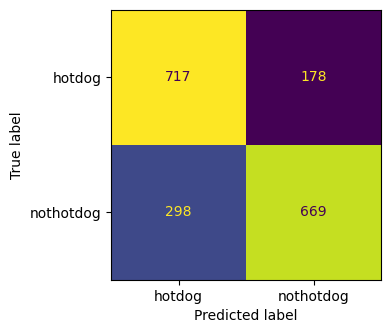

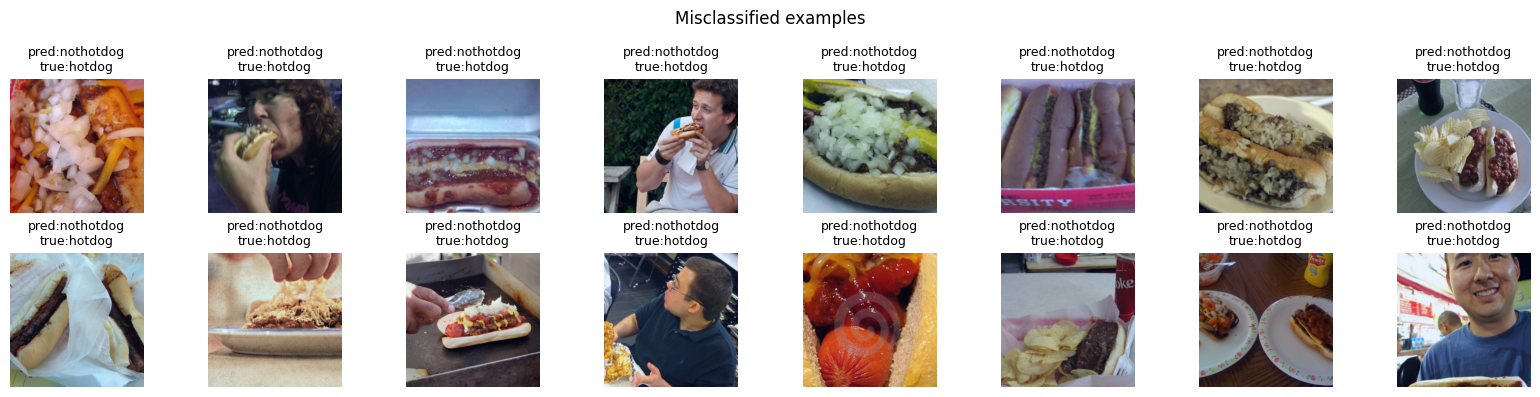


== SmallCNN+BN on TEST ==
Accuracy: 0.7390

              precision    recall  f1-score   support

      hotdog     0.7225    0.7419    0.7321       895
   nothotdog     0.7550    0.7363    0.7455       967

    accuracy                         0.7390      1862
   macro avg     0.7388    0.7391    0.7388      1862
weighted avg     0.7394    0.7390    0.7391      1862



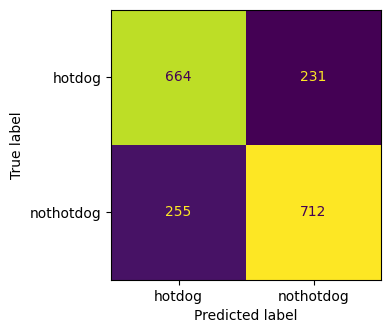

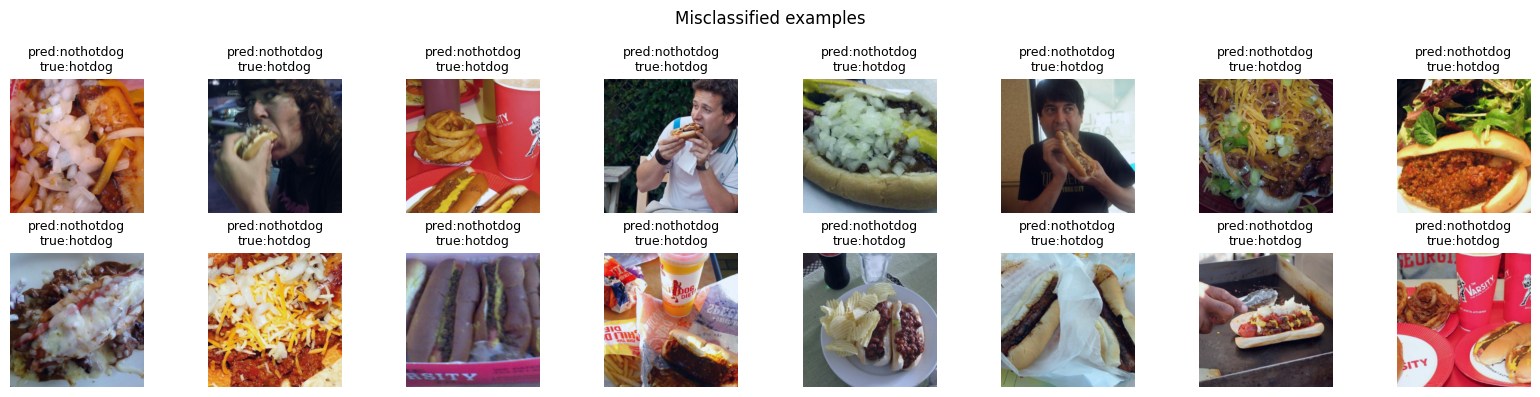


== SmallCNN+Dropout on TEST ==
Accuracy: 0.7610

              precision    recall  f1-score   support

      hotdog     0.7339    0.7888    0.7604       895
   nothotdog     0.7900    0.7353    0.7616       967

    accuracy                         0.7610      1862
   macro avg     0.7619    0.7620    0.7610      1862
weighted avg     0.7630    0.7610    0.7610      1862



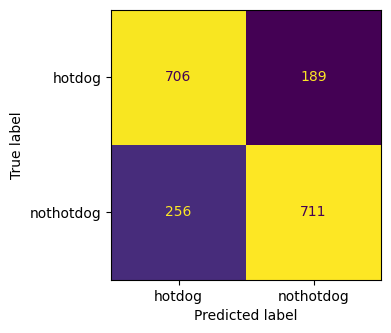

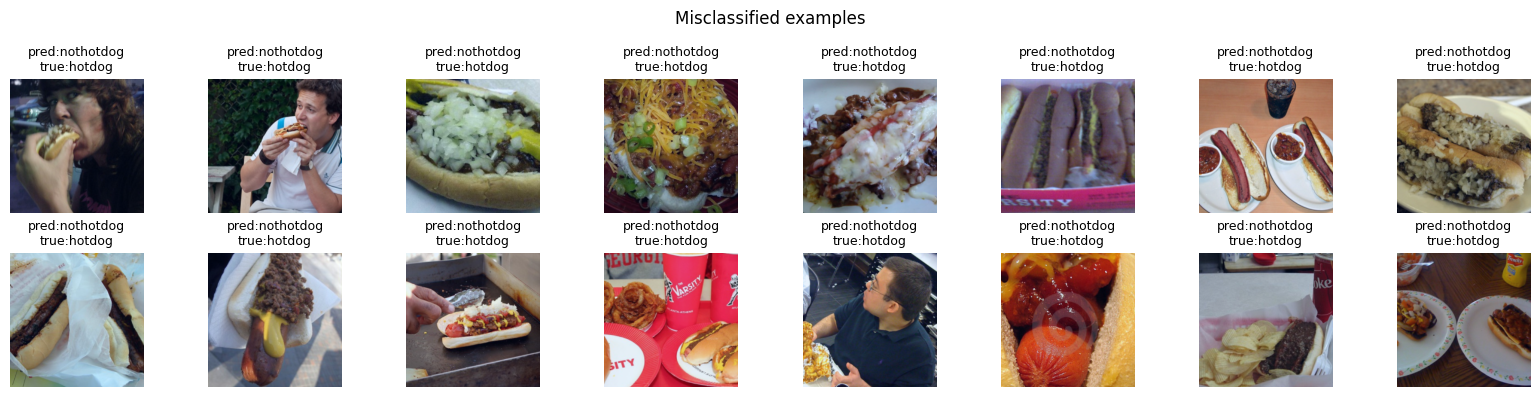


== ResNet18 on TEST ==
Accuracy: 0.8931

              precision    recall  f1-score   support

      hotdog     0.8824    0.8972    0.8898       895
   nothotdog     0.9034    0.8893    0.8963       967

    accuracy                         0.8931      1862
   macro avg     0.8929    0.8933    0.8930      1862
weighted avg     0.8933    0.8931    0.8932      1862



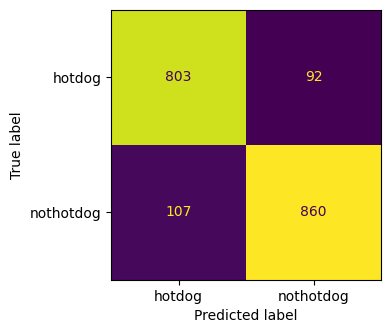

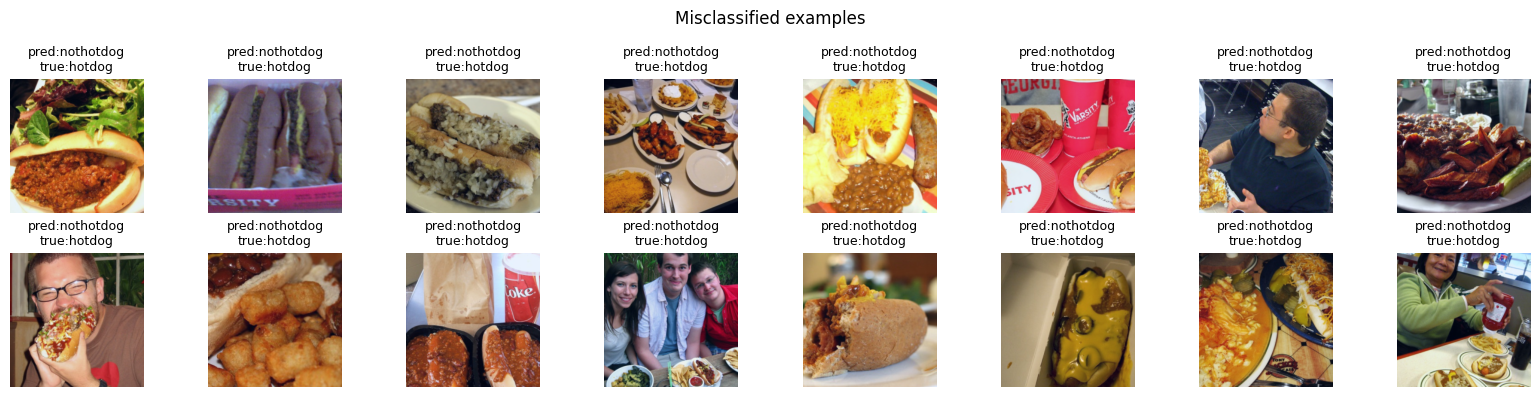

In [20]:
# 5) TEST evaluation (report only, no tuning)
print("\n== SmallCNN on TEST ==")
acc_base    = eval_and_report(model_base,    test_loader, class_names, tag="base")
print("\n== SmallCNN+BN on TEST ==")
acc_base_bn = eval_and_report(model_base_bn, test_loader, class_names, tag="base_bn")
print("\n== SmallCNN+Dropout on TEST ==")
acc_base_do = eval_and_report(model_base_do, test_loader, class_names, tag="base_do")
print("\n== ResNet18 on TEST ==")
acc_res     = eval_and_report(model_res,     test_loader, class_names, tag="resnet18")

# 6) save separate checkpoints (avoid overwrite)
try:
    OUTDIR.mkdir(parents=True, exist_ok=True)
    torch.save(model_base.state_dict(),     OUTDIR / "base_best.ckpt")
    torch.save(model_base_bn.state_dict(),  OUTDIR / "base_bn_best.ckpt")
    torch.save(model_base_do.state_dict(),  OUTDIR / "base_do_best.ckpt")
    torch.save(model_res.state_dict(),      OUTDIR / "resnet18_best.ckpt")
except Exception as e:
    print("[warn] save ckpt failed:", e)


/var/folders/k6/18s4hr7n4xv6tk2jrjw6t3wr0000gn/T/ipykernel_24215/3209418428.py:28: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=(device.type=='cuda'))
/var/folders/k6/18s4hr7n4xv6tk2jrjw6t3wr0000gn/T/ipykernel_24215/3209418428.py:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device.type=='cuda')):


Epoch 001  loss 0.3909/0.7849  acc 0.832/0.771
Epoch 002  loss 0.2391/0.5551  acc 0.888/0.844
Epoch 003  loss 0.1549/0.4064  acc 0.938/0.837
Epoch 004  loss 0.0682/0.7784  acc 0.971/0.854
Epoch 005  loss 0.0550/0.4281  acc 0.977/0.866
Epoch 006  loss 0.0504/0.6464  acc 0.980/0.856
Epoch 007  loss 0.0178/0.3445  acc 0.996/0.905
Epoch 008  loss 0.0049/0.3587  acc 0.999/0.915
Epoch 009  loss 0.0026/0.3663  acc 1.000/0.920
Epoch 010  loss 0.0020/0.3674  acc 1.000/0.917
Accuracy: 0.8926

              precision    recall  f1-score   support

      hotdog     0.9162    0.8547    0.8844       895
   nothotdog     0.8734    0.9276    0.8997       967

    accuracy                         0.8926      1862
   macro avg     0.8948    0.8912    0.8920      1862
weighted avg     0.8940    0.8926    0.8923      1862



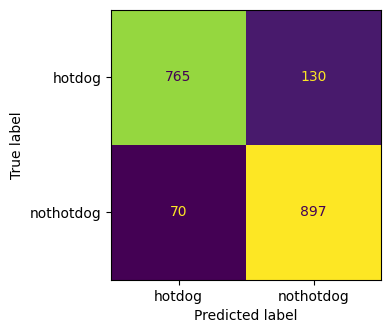

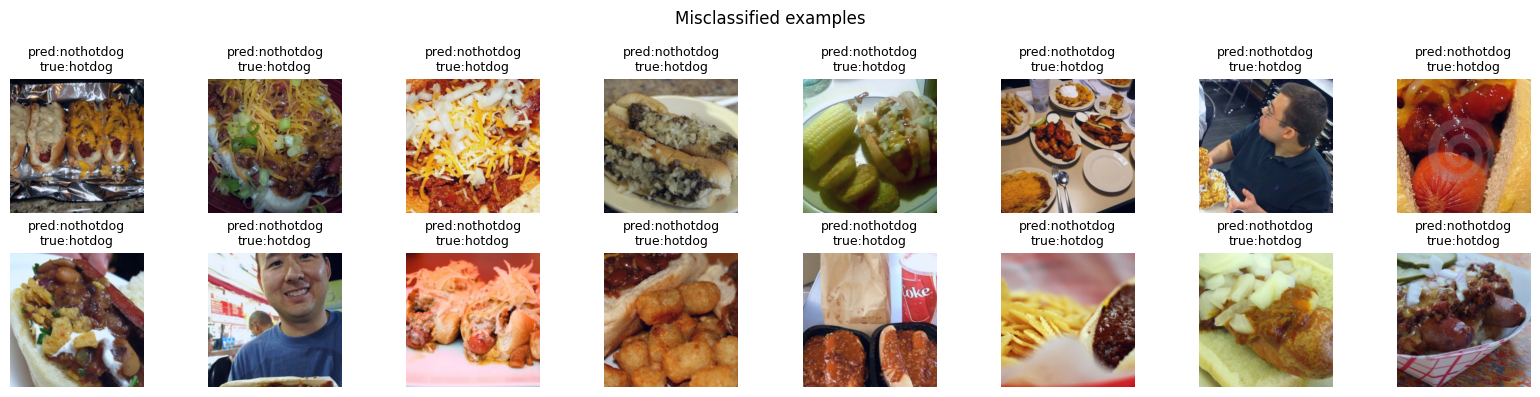

/var/folders/k6/18s4hr7n4xv6tk2jrjw6t3wr0000gn/T/ipykernel_24215/3209418428.py:28: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=(device.type=='cuda'))
/var/folders/k6/18s4hr7n4xv6tk2jrjw6t3wr0000gn/T/ipykernel_24215/3209418428.py:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device.type=='cuda')):


Epoch 001  loss 0.4118/1.1717  acc 0.829/0.695
Epoch 002  loss 0.2370/0.5390  acc 0.890/0.739
Epoch 003  loss 0.1626/0.7864  acc 0.927/0.737
Epoch 004  loss 0.1337/0.3815  acc 0.943/0.859
Epoch 005  loss 0.0743/0.3958  acc 0.974/0.871
Epoch 006  loss 0.0425/0.4484  acc 0.990/0.856
Epoch 007  loss 0.0345/0.3386  acc 0.987/0.878
Epoch 008  loss 0.0209/0.4167  acc 0.993/0.876
Epoch 009  loss 0.0092/0.3756  acc 0.998/0.885
Epoch 010  loss 0.0067/0.3682  acc 0.999/0.893
Accuracy: 0.9001

              precision    recall  f1-score   support

      hotdog     0.9089    0.8804    0.8944       895
   nothotdog     0.8925    0.9183    0.9052       967

    accuracy                         0.9001      1862
   macro avg     0.9007    0.8994    0.8998      1862
weighted avg     0.9004    0.9001    0.9000      1862



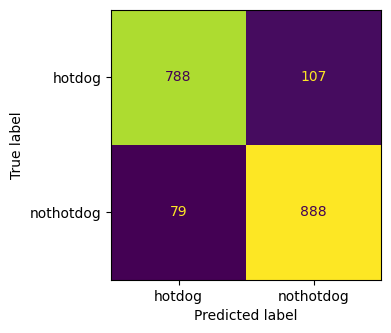

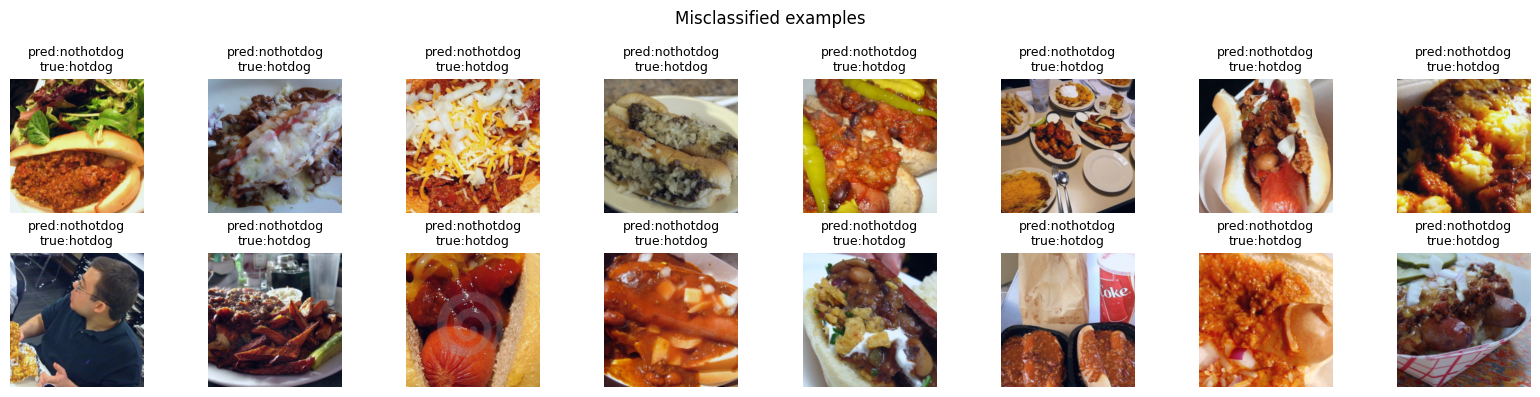

/var/folders/k6/18s4hr7n4xv6tk2jrjw6t3wr0000gn/T/ipykernel_24215/3209418428.py:28: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=(device.type=='cuda'))
/var/folders/k6/18s4hr7n4xv6tk2jrjw6t3wr0000gn/T/ipykernel_24215/3209418428.py:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device.type=='cuda')):


Epoch 001  loss 0.4854/2.6578  acc 0.797/0.593
Epoch 002  loss 0.3036/0.4587  acc 0.862/0.841


In [ ]:
# All-in-one experiment panel (drop-in) — 去重版 + (G/H) 新增对比图
# 依赖：ROOT, IMG, BATCH, WORKERS, EPOCHS, LR, OPTIMIZER, SCHEDULER, OUTDIR,
#      build_transforms, Hotdog_NotHotdog, eval_and_report, class_names,
#      SmallCNN, build_model, train_one_model, 以及 train_idx / val_idx（80/20 固定划分）

import math, numpy as np, pandas as pd
from pathlib import Path
from torch.utils.data import Subset, DataLoader
import matplotlib.pyplot as plt
from IPython.display import display  # 用于表格展示

# 通用“单图多曲线”
def _plot_all_on_one(hists, labels, metric='val_acc', title='Title', fname='figure.png'):
    plt.figure(figsize=(7.5,5.2))
    for h, lab in zip(hists, labels):
        y = h[metric]
        x = list(range(1, len(y)+1))
        plt.plot(x, y, label=f"{lab} (best={max(y):.3f})")
        plt.scatter([x[-1]], [y[-1]], s=18)
    plt.xlabel("epoch"); plt.ylabel(metric.replace('_',' '))
    plt.title(title); plt.grid(alpha=0.3); plt.legend()
    try:
        OUTDIR.mkdir(parents=True, exist_ok=True)
        plt.tight_layout(); plt.savefig(OUTDIR / fname, dpi=150)
    except Exception as e:
        print("[warn] save figure failed:", e)
    plt.show()

# 工具：基于 aug key 重建一致划分的 loaders（复用已有数据类与增强）
def make_loaders_with_aug(augment_key):
    # 如果请求增强键与全局一致且已有 loaders，直接复用，避免重复构建
    if 'AUGMENT_KEY' in globals() and augment_key == AUGMENT_KEY \
       and all(k in globals() for k in ['train_loader','val_loader','test_loader']):
        return train_loader, val_loader, test_loader

    train_tf, eval_tf = build_transforms(IMG, augment_key)
    ds_train_for_train = Hotdog_NotHotdog(train=True,  transform=train_tf,  data_path=ROOT)
    ds_train_for_val   = Hotdog_NotHotdog(train=True,  transform=eval_tf,   data_path=ROOT)
    ds_test            = Hotdog_NotHotdog(train=False, transform=eval_tf,   data_path=ROOT)
    tr = Subset(ds_train_for_train, train_idx)
    va = Subset(ds_train_for_val,   val_idx)
    tl = DataLoader(tr, batch_size=BATCH, shuffle=True,  num_workers=WORKERS)
    vl = DataLoader(va, batch_size=BATCH, shuffle=False, num_workers=WORKERS)
    te = DataLoader(ds_test, batch_size=BATCH, shuffle=False, num_workers=WORKERS)
    return tl, vl, te

#  A) 数据增强对比
def run_aug(name, aug_key, kind='resnet18'):
    tl, vl, te = make_loaders_with_aug(aug_key)
    m, h, best_val = train_one_model(kind=kind, train_loader=tl, val_loader=vl,
                                     epochs=EPOCHS, lr=LR,
                                     optimizer_name=OPTIMIZER, scheduler_name=SCHEDULER, patience=5)
    test_acc = eval_and_report(m, te, class_names)
    return {"Aug": name, "Val_Acc": float(best_val), "Test_Acc": float(test_acc)}

aug_runs = [
    ("Baseline_RESIZE", "Baseline_RESIZE"),
    ("LightCombo", "G_hflip_P_light_R_erasing"),
    ("RandAugment", "A_randaugment"),  # 或改成 A_autoaugment
]
df_aug = pd.DataFrame([run_aug(n,k) for n,k in aug_runs])
display(df_aug)
df_aug.to_csv(OUTDIR/"aug_compare.csv", index=False)

#  B) 优化器 / 调度器 对比（基线增强）
def run_opt_sched(opt_name, sched_name, label, aug_key="Baseline_RESIZE", kind='resnet18'):
    tl, vl, te = make_loaders_with_aug(aug_key)
    m, h, best_val = train_one_model(kind=kind, train_loader=tl, val_loader=vl,
                                     epochs=EPOCHS, lr=LR,
                                     optimizer_name=opt_name, scheduler_name=sched_name, patience=5)
    test_acc = eval_and_report(m, te, class_names)
    return {"Setting": label, "Val_Acc": float(best_val), "Test_Acc": float(test_acc)}

opt_sched_results = [
    run_opt_sched("adam","cosine","Adam + Cosine"),
    run_opt_sched("adam","step","Adam + StepLR"),
    run_opt_sched("sgd","cosine","SGD + Cosine"),
    run_opt_sched("sgd","step","SGD + StepLR"),
]
df_os = pd.DataFrame(opt_sched_results)
display(df_os)
df_os.to_csv(OUTDIR/"optimizer_scheduler_compare.csv", index=False)

#  C) SmallCNN 变体对比（base / base_bn / base_do）
def run_smallcnn_variant(kind, label, aug_key="Baseline_RESIZE"):
    tl, vl, te = make_loaders_with_aug(aug_key)
    m, h, best_val = train_one_model(kind=kind, train_loader=tl, val_loader=vl,
                                     epochs=EPOCHS, lr=LR,
                                     optimizer_name=OPTIMIZER, scheduler_name=SCHEDULER, patience=5)
    test_acc = eval_and_report(m, te, class_names)
    return label, best_val, test_acc

small_rows = []
for k,label in [('base','SmallCNN'), ('base_bn','SmallCNN+BN'), ('base_do','SmallCNN+Dropout')]:
    lab, bv, ta = run_smallcnn_variant(k, label)
    small_rows.append({"Model": lab, "Val_Acc": float(bv), "Test_Acc": float(ta)})
df_small = pd.DataFrame(small_rows)
display(df_small)
df_small.to_csv(OUTDIR/"smallcnn_variants_compare.csv", index=False)

# D) 迁移学习消融（pretrained / freeze）
def run_resnet18_variant(pretrained, freeze, aug_key="Baseline_RESIZE"):
    tl, vl, te = make_loaders_with_aug(aug_key)
    m, h, best_val = train_one_model(kind='resnet18', train_loader=tl, val_loader=vl,
                                     epochs=EPOCHS, lr=LR,
                                     optimizer_name=OPTIMIZER, scheduler_name=SCHEDULER, patience=5,
                                     freeze_backbone=freeze, pretrained=pretrained)
    test_acc = eval_and_report(m, te, class_names)
    return m, {"Setting": f"pretrained={pretrained}, freeze={freeze}",
               "Val_Acc": float(best_val), "Test_Acc": float(test_acc)}

models_for_pick = []
rows = []
for pre, frz in [(True, False), (True, True), (False, False)]:
    m, row = run_resnet18_variant(pre, frz)
    models_for_pick.append((m, row["Test_Acc"]))
    rows.append(row)
df_tl = pd.DataFrame(rows)
display(df_tl)
df_tl.to_csv(OUTDIR/"transfer_ablation.csv", index=False)

# 取测试精度最高的一个，用于误分类可视化
model_for_err = max(models_for_pick, key=lambda t: t[1])[0]

#  E) 误分类“两方向”分别可视化
def viz_misclassified_two_sides(model, loader, class_names=None, max_each=6):
    import torch
    model.eval()
    wrong_01, wrong_10 = [], []  # 0->1: true 0 pred 1；1->0: true 1 pred 0
    with torch.no_grad():
        for X,y in loader:
            dev = next(model.parameters()).device
            X = X.to(dev); y = y.to(dev)
            p = model(X).argmax(1)
            for i in range(X.size(0)):
                if len(wrong_01)>=max_each and len(wrong_10)>=max_each: break
                if y[i]==0 and p[i]==1 and len(wrong_01)<max_each: wrong_01.append(X[i].cpu())
                if y[i]==1 and p[i]==0 and len(wrong_10)<max_each: wrong_10.append(X[i].cpu())

    def _grid(imgs, title, fname):
        if not imgs: return
        k=len(imgs); cols=3; rows=math.ceil(k/cols)
        plt.figure(figsize=(cols*2.3, rows*2.3))
        for i,img in enumerate(imgs):
            ax=plt.subplot(rows,cols,i+1)
            v=(img - img.min())/(img.max()-img.min()+1e-6)
            ax.imshow(v.permute(1,2,0)); ax.axis('off')
        plt.suptitle(title); plt.tight_layout()
        plt.savefig(OUTDIR/fname); plt.show()

    _grid(wrong_10, "pred: not-hotdog / true: hotdog", "wrong_hotdog_to_not.png")
    _grid(wrong_01, "pred: hotdog / true: not-hotdog", "wrong_not_to_hotdog.png")

# 用上面挑出的最佳 ResNet18 模型做误分可视化
_, _, te_vis = make_loaders_with_aug("Baseline_RESIZE")
viz_misclassified_two_sides(model_for_err, te_vis, class_names)

# F) 数据集统计/清洗结果表（复用已计算的 stats）
try:
    _ = stats
except NameError:
    # 如果确实没有 stats（例如单独运行此面板），做一次轻量统计（不搬移文件）
    from PIL import Image, UnidentifiedImageError
    import os, glob
    def _quick_scan_counts(root):
        root = Path(root); out = {}
        for split in ['train','test']:
            out[split] = {}
            d = root/split
            if not d.exists(): continue
            for cdir in sorted([p for p in d.iterdir() if p.is_dir()]):
                files = sum([list(cdir.glob(pat)) for pat in ('*.jpg','*.jpeg','*.png','*.JPG','*.JPEG','*.PNG')], [])
                out[split][cdir.name] = len(files)
        return out
    stats = _quick_scan_counts(ROOT)

rows=[]
for split, d in stats.items():
    for cls, n in d.items():
        rows.append({"split":split, "class":cls, "count":n})
df_counts = pd.DataFrame(rows).sort_values(["split","class"])
display(df_counts)
df_counts.to_csv(OUTDIR/"dataset_counts.csv", index=False)

print("All comparison tables are saved in:", OUTDIR)


# G) 图1：在“水平翻转”增强下，SmallCNN 与 ResNet18 的 Adam vs SGD 对比
#    - 使用 augment_key = "G_hflip"
def run_optimizer_compare_hflip():
    aug_key = "G_hflip"   # 即 RandomHorizontalFlip()
    settings = [
        ("SmallCNN-Adam", "base",     "adam"),
        ("SmallCNN-SGD",  "base",     "sgd"),
        ("ResNet18-Adam", "resnet18", "adam"),
        ("ResNet18-SGD",  "resnet18", "sgd"),
    ]
    hists, labels, rows = [], [], []
    for label, kind, opt in settings:
        tl, vl, te = make_loaders_with_aug(aug_key)
        m, h, best_val = train_one_model(kind=kind, train_loader=tl, val_loader=vl,
                                         epochs=EPOCHS, lr=LR,
                                         optimizer_name=opt, scheduler_name=SCHEDULER, patience=5)
        hists.append(h); labels.append(label)
        rows.append({"Model+Opt": label, "Val_Acc_best": float(best_val)})
    df = pd.DataFrame(rows)
    display(df)
    df.to_csv(OUTDIR/"hflip_optimizer_compare.csv", index=False)
    _plot_all_on_one(hists, labels, metric='val_acc',
                     title='Adam vs SGD under Horizontal Flip (SmallCNN & ResNet18)',
                     fname='fig_optimizer_hflip.png')

run_optimizer_compare_hflip()

# H) 图2：在“水平翻转”增强下，SmallCNN 与 ResNet18 的 CosineAnnealingLR vs StepLR 对比
#    - 固定优化器为全局 OPTIMIZER，比较 scheduler
def run_scheduler_compare_hflip():
    aug_key = "G_hflip"
    settings = [
        ("SmallCNN-Cosine", "base",     "cosine"),
        ("SmallCNN-StepLR", "base",     "step"),
        ("ResNet18-Cosine", "resnet18", "cosine"),
        ("ResNet18-StepLR", "resnet18", "step"),
    ]
    hists, labels, rows = [], [], []
    for label, kind, sched in settings:
        tl, vl, te = make_loaders_with_aug(aug_key)
        m, h, best_val = train_one_model(kind=kind, train_loader=tl, val_loader=vl,
                                         epochs=EPOCHS, lr=LR,
                                         optimizer_name=OPTIMIZER, scheduler_name=sched, patience=5)
        hists.append(h); labels.append(label)
        rows.append({"Model+Sched": label, "Val_Acc_best": float(best_val)})
    df = pd.DataFrame(rows)
    display(df)
    df.to_csv(OUTDIR/"hflip_scheduler_compare.csv", index=False)
    _plot_all_on_one(hists, labels, metric='val_acc',
                     title='CosineAnnealingLR vs StepLR under Horizontal Flip (SmallCNN & ResNet18)',
                     fname='fig_scheduler_hflip.png')

run_scheduler_compare_hflip()


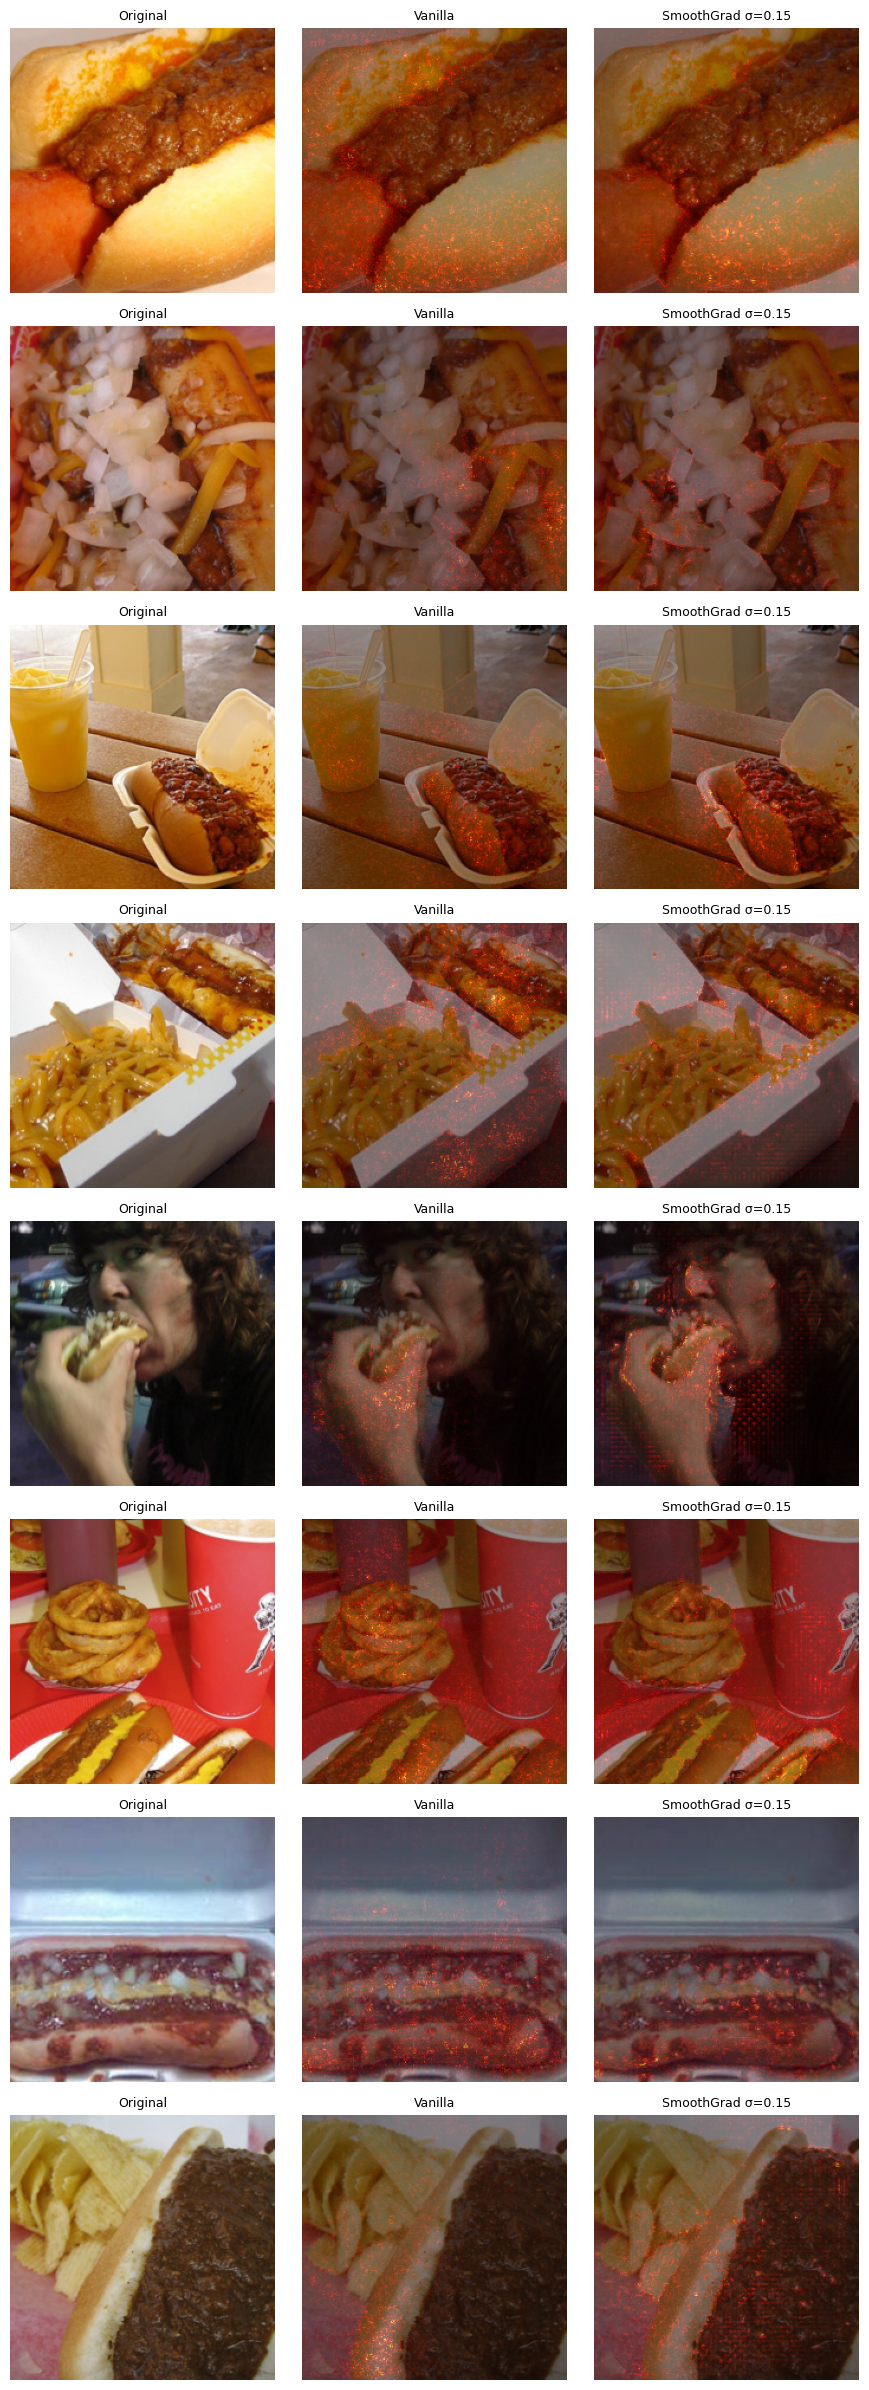

In [ ]:
# Cell 12 : saliency (vanilla + smoothgrad)
def denorm(img_chw, mean=TRAINSET_MEAN, std=TRAINSET_STD, enabled=True):
    x = img_chw.detach().cpu().clone()
    if enabled:
        for c, (m, s) in enumerate(zip(mean, std)):
            x[c] = x[c] * s + m
    return x.clamp(0, 1)

def saliency_map(model, img_tensor, target_class=None, take_abs=True, to_numpy=True):
    """
    Vanilla Saliency: d logit_c / d input
    """
    model.eval()
    device = next(model.parameters()).device
    with torch.enable_grad():                               # 显式打开梯度
        x = img_tensor.clone().to(device).unsqueeze(0)      # [1,C,H,W]
        x.requires_grad_(True)
        logits = model(x)                                   # [1,num_classes]
        cls = int(logits.argmax(1).item() if target_class is None else target_class)
        model.zero_grad(set_to_none=True)
        logits[0, cls].backward()                           # d logit_cls / d x
        g = x.grad.detach().squeeze(0)                      # [C,H,W]
    if take_abs:
        g = g.abs()
    sal = g.max(dim=0).values                               # [H,W]
    sal = (sal - sal.min())/(sal.max() + 1e-8)
    return (sal.cpu().numpy() if to_numpy else sal.cpu()), cls

def smoothgrad_saliency(model, img_tensor, target_class=None, n_samples=SALIENCY_N, sigma=SALIENCY_SIGMA):
    """
    SmoothGrad: 对输入多次加噪声，平均梯度。
    """
    model.eval()
    device = next(model.parameters()).device
    x0 = img_tensor.clone().to(device)

    # 先确定目标类别（用预测或用户指定）
    with torch.enable_grad():
        x_tmp = x0.unsqueeze(0).requires_grad_(True)
        logits = model(x_tmp)
        cls = int(logits.argmax(1).item() if target_class is None else target_class)

    acc = torch.zeros_like(x0)
    for _ in range(n_samples):
        with torch.enable_grad():
            xn = (x0 + torch.randn_like(x0)*sigma).clamp(0,1).unsqueeze(0)
            xn.requires_grad_(True)
            model.zero_grad(set_to_none=True)
            s = model(xn)[0, cls]
            s.backward()
            acc += xn.grad.detach().squeeze(0)

    g = acc / max(1, n_samples)
    g = g.abs().max(dim=0).values                           # [H,W]
    g = (g - g.min())/(g.max() + 1e-8)
    return g.cpu().numpy(), cls

def show_saliency_grid_compare(model, loader, class_names=None, k=SALIENCY_K, alpha=0.45, sigma=SALIENCY_SIGMA, n_samples=SALIENCY_N):
    """
    每张图显示：Original | Vanilla | SmoothGrad
    """
    X, y = next(iter(loader))
    k = min(k, X.size(0))
    rows, cols = k, 3
    plt.figure(figsize=(cols*3, rows*3))
    for i in range(k):
        img = X[i]
        van, _ = saliency_map(model, img)
        smg, _ = smoothgrad_saliency(model, img, n_samples=n_samples, sigma=sigma)
        vis = denorm(img).permute(1,2,0).numpy()

        ax = plt.subplot(rows, cols, i*3+1); ax.imshow(vis); ax.axis('off'); ax.set_title("Original", fontsize=9)
        ax = plt.subplot(rows, cols, i*3+2); ax.imshow(vis); ax.imshow(van, cmap='hot', alpha=alpha); ax.axis('off'); ax.set_title("Vanilla", fontsize=9)
        ax = plt.subplot(rows, cols, i*3+3); ax.imshow(vis); ax.imshow(smg, cmap='hot', alpha=alpha); ax.axis('off'); ax.set_title(f"SmoothGrad σ={sigma}", fontsize=9)
    plt.tight_layout(); plt.savefig(OUTDIR/"saliency_grid.png"); plt.show()

# 选择一个模型做可视化（保持你原来的逻辑）
_model_for_vis = model_res if 'model_res' in globals() else model_base
show_saliency_grid_compare(_model_for_vis, test_loader, class_names, k=SALIENCY_K, sigma=SALIENCY_SIGMA, n_samples=SALIENCY_N)
